In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Install and import required libraries
!pip install pyspark findspark seaborn matplotlib pandas -q

import os, findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, round as sround, col


Mounted at /content/drive


In [2]:
import findspark
findspark.init()

print("✅ Findspark Initialized")

✅ Findspark Initialized


In [5]:
!pip uninstall -y pyspark


Found existing installation: pyspark 3.5.1
Uninstalling pyspark-3.5.1:
  Successfully uninstalled pyspark-3.5.1


In [7]:
!
!sudo apt-get update -qq > /dev/null
!apt-get install -qq openjdk-11-jdk-headless > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz -O spark.tgz
!tar xf spark.tgz
!pip install -q findspark pyarrow pandas pyspark==3.5.1 seaborn matplotlib

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [8]:
import os, findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"   # ✅ corrected path
findspark.init()

print("✅ Java and Spark 3.5.1 environment configured")


✅ Java and Spark 3.5.1 environment configured


In [9]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Flight_Delay_Visualization")
    .master("local[*]")
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") # Explicitly disable Arrow
    .config("spark.sql.catalogImplementation", "in-memory") # Add this configuration
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "2g")
    .config("spark.sql.shuffle.partitions", "4")
    .getOrCreate()
)

print("✅ Spark session ready")
spark.range(5).show()

✅ Spark session ready
+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [ ]:
!java -version

In [10]:
cleaned_path = "/content/drive/MyDrive/flight_delay_analysis_project/Data_Processed/cleaned_flights.parquet"
df = spark.read.parquet(cleaned_path)
print(f"✅ Data loaded successfully with {df.count()} rows and {len(df.columns)} columns")


✅ Data loaded successfully with 622268174 rows and 46 columns


In [11]:
# ⚙️ Use a very small random sample to fit in Colab memory
df_small = df.sample(False, 0.001, seed=42).cache()  # 0.1% sample ≈ 62k rows
sample_df = df_small.limit(50000).toPandas()         # hard cap at 50k rows

print(f"✅ Random sample created successfully: {sample_df.shape}")
print("Unique Airlines in Sample:", sample_df["AIRLINE"].unique())
sample_df.head()


✅ Random sample created successfully: (50000, 46)
Unique Airlines in Sample: ['OO' 'DL' 'UA' 'US' 'MQ' 'HA' 'WN' 'AS' 'EV']


,YEAR,MONTH,AIRLINE,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,agg_arr_delay,agg_carrier_delay,nas_delay
0,2015,1,OO,1,4,5604,N292SW,ACV,SFO,600,...,15.56,3.57,8.02,0.00,21.86,12.0,1.0,3291.0,1151.0,388.0
1,2015,1,OO,1,4,5170,N791SK,DAL,IAH,600,...,8.15,0.00,7.14,0.00,11.70,4.0,1.0,1016.0,424.0,189.0
2,2015,1,OO,1,4,5429,N958SW,PAH,ORD,600,...,19.91,0.55,7.64,0.00,17.89,2.0,0.0,3099.0,1626.0,392.0
3,2015,1,OO,1,4,6332,N708SK,DFW,DEN,600,...,63.06,15.20,58.85,0.00,81.89,30.0,0.0,14719.0,3926.0,2666.0
4,2015,1,OO,1,4,6403,N983SW,MFR,SFO,600,...,14.37,0.95,7.80,0.81,21.06,3.0,0.0,3084.0,1107.0,295.0


In [12]:
import pandas as pd

# Safety check
needed = {"AIRLINE", "ARRIVAL_DELAY"}
missing = needed - set(sample_df.columns)
assert not missing, f"Missing columns: {missing}"

avg_delay_airline = (
    sample_df.groupby("AIRLINE", as_index=False)["ARRIVAL_DELAY"]
             .mean()
             .rename(columns={"ARRIVAL_DELAY": "AVG_ARRIVAL_DELAY"})
)


/tmp/ipython-input-3823684687.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


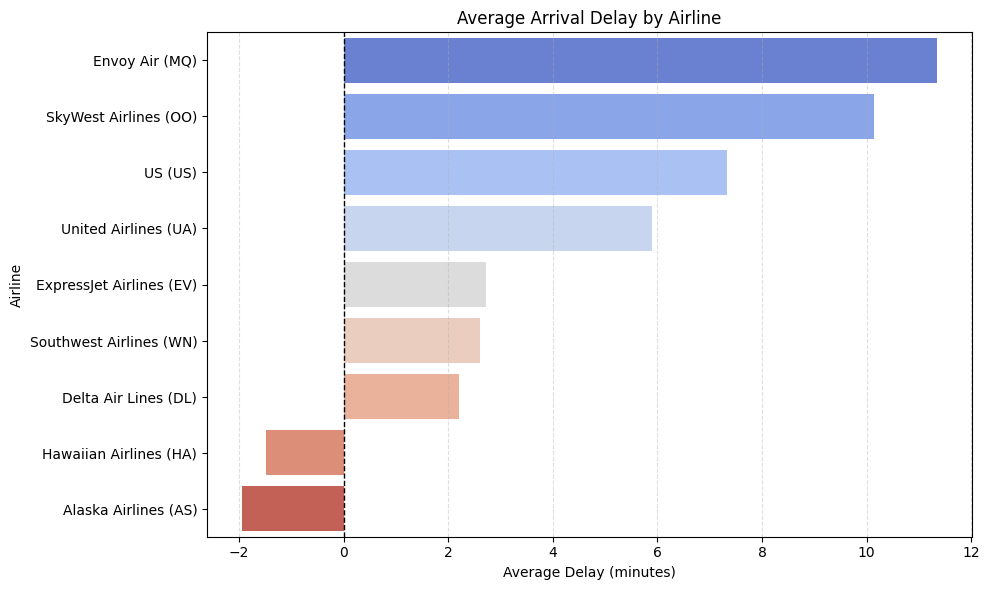

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

airline_map = {
    "AA":"American Airlines","DL":"Delta Air Lines","UA":"United Airlines",
    "WN":"Southwest Airlines","AS":"Alaska Airlines","B6":"JetBlue Airways",
    "OO":"SkyWest Airlines","EV":"ExpressJet Airlines","HA":"Hawaiian Airlines",
    "MQ":"Envoy Air"  # add others if needed
}

avg_delay_airline["AIRLINE_FULL"] = avg_delay_airline["AIRLINE"].map(
    lambda x: f"{airline_map.get(x, x)} ({x})"
)

# sort for nicer plot
avg_delay_airline = avg_delay_airline.sort_values("AVG_ARRIVAL_DELAY", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    data=avg_delay_airline,
    y="AIRLINE_FULL", x="AVG_ARRIVAL_DELAY",
    palette="coolwarm", orient="h"
)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Average Arrival Delay by Airline")
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Airline")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1853387265.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_trend["TOTAL_DELAY"].fillna(0, inplace=True)


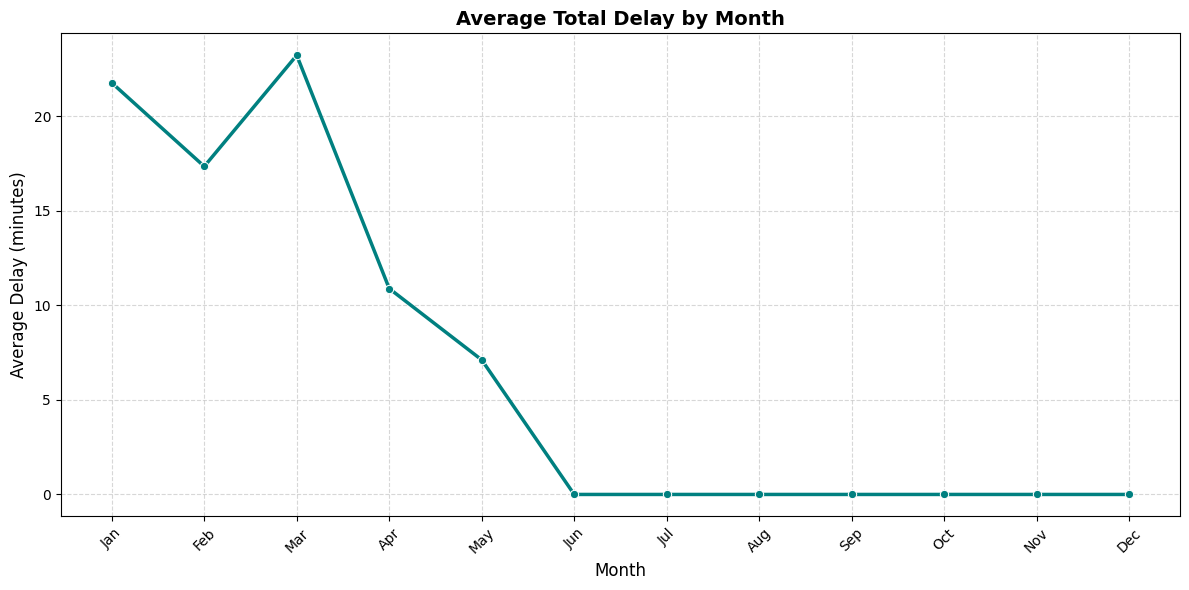

In [14]:
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

# Group by MONTH and calculate average delay
monthly_trend = (
    sample_df.groupby("MONTH")["TOTAL_DELAY"]
    .mean()
    .reset_index()
)

# Ensure all 12 months appear, even if missing in sample
all_months = pd.DataFrame({"MONTH": range(1, 13)})
monthly_trend = all_months.merge(monthly_trend, on="MONTH", how="left")
monthly_trend["TOTAL_DELAY"].fillna(0, inplace=True)

# Convert month numbers to month names
monthly_trend["MONTH_NAME"] = monthly_trend["MONTH"].apply(lambda x: calendar.month_abbr[x])

# Plot the trend
plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_trend,
    x="MONTH_NAME",
    y="TOTAL_DELAY",
    marker="o",
    linewidth=2.5,
    color="teal"
)

# Chart aesthetics
plt.title("Average Total Delay by Month", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
# Define a list of hub airports (you can modify this)
hub_airports = ['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'JFK', 'SFO', 'SEA', 'MIA', 'CLT']

# Create a new column 'ORIGIN_IS_HUB'
sample_df["ORIGIN_IS_HUB"] = sample_df["ORIGIN_AIRPORT"].apply(lambda x: 1 if x in hub_airports else 0)

# Verify
sample_df[["ORIGIN_AIRPORT", "ORIGIN_IS_HUB"]].head()


,ORIGIN_AIRPORT,ORIGIN_IS_HUB
0,ACV,0
1,DAL,0
2,PAH,0
3,DFW,1
4,MFR,0


/tmp/ipython-input-3053020434.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hub_comparison, x="ORIGIN_IS_HUB", y="TOTAL_DELAY", palette="coolwarm")


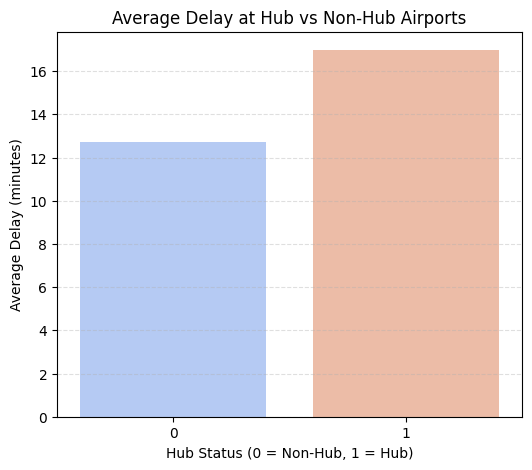

In [16]:
hub_comparison = (
    sample_df.groupby("ORIGIN_IS_HUB")["TOTAL_DELAY"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,5))
sns.barplot(data=hub_comparison, x="ORIGIN_IS_HUB", y="TOTAL_DELAY", palette="coolwarm")
plt.title("Average Delay at Hub vs Non-Hub Airports")
plt.xlabel("Hub Status (0 = Non-Hub, 1 = Hub)")
plt.ylabel("Average Delay (minutes)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [17]:
import plotly.express as px

# Prepare the same data
route_delay = (
    sample_df.groupby(["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])["ARRIVAL_DELAY"]
    .mean()
    .reset_index()
    .sort_values("ARRIVAL_DELAY", ascending=False)
    .head(10)
)

# Create an interactive horizontal bar chart
fig = px.bar(
    route_delay,
    x="ARRIVAL_DELAY",
    y="ORIGIN_AIRPORT",
    color="DESTINATION_AIRPORT",
    orientation="h",
    color_continuous_scale="Viridis",
    title="Top 10 Most Delay-Prone Routes",
    hover_data={
        "ORIGIN_AIRPORT": True,
        "DESTINATION_AIRPORT": True,
        "ARRIVAL_DELAY": ':.2f'
    },
    labels={
        "ARRIVAL_DELAY": "Average Arrival Delay (minutes)",
        "ORIGIN_AIRPORT": "Origin Airport",
        "DESTINATION_AIRPORT": "Destination"
    }
)

# Beautify layout
fig.update_layout(
    title_font_size=16,
    xaxis_title="Average Arrival Delay (minutes)",
    yaxis_title="Origin Airport",
    template="plotly_white"
)

fig.show()


In [18]:
[col for col in sample_df.columns if "delay" in col.lower()]


['DEPARTURE_DELAY',
 'ARRIVAL_DELAY',
 'AIR_SYSTEM_DELAY',
 'AIRLINE_DELAY',
 'TOTAL_DELAY',
 'agg_arr_delay',
 'agg_carrier_delay',
 'nas_delay']

In [19]:
sample_df["nas_delay"] = sample_df["nas_delay"].clip(0, 600)


In [20]:
sample_df = sample_df[sample_df["nas_delay"] < 1000]


In [21]:
sample_df[["AIR_SYSTEM_DELAY", "AIRLINE_DELAY", "nas_delay"]].describe()


,AIR_SYSTEM_DELAY,AIRLINE_DELAY,nas_delay
count,9167.000000,9167.000000,50000.00000
mean,12.633359,19.413876,288.92772
std,26.648271,47.239347,229.61576
min,0.000000,0.000000,0.00000
25%,0.000000,0.000000,73.00000
50%,2.000000,1.000000,229.00000
75%,17.000000,19.000000,600.00000
max,824.000000,941.000000,600.00000


In [22]:
import plotly.express as px
import pandas as pd

# Use available columns
delay_causes = {
    "Departure Delay": sample_df["DEPARTURE_DELAY"].mean(),
    "Arrival Delay": sample_df["ARRIVAL_DELAY"].mean(),
    "Air System Delay": sample_df["AIR_SYSTEM_DELAY"].mean(),
    "Airline Delay": sample_df["AIRLINE_DELAY"].mean(),
    "NAS Delay": sample_df["nas_delay"].mean()  # lowercase version
}

# Convert to DataFrame
cause_df = pd.DataFrame(list(delay_causes.items()), columns=["Cause", "Average Delay (minutes)"])

# Plot interactive donut chart
fig = px.pie(
    cause_df,
    names="Cause",
    values="Average Delay (minutes)",
    hole=0.4,
    color_discrete_sequence=px.colors.qualitative.Pastel,
    title="Proportion of Average Delay Causes"
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_font_size=16)
fig.show()


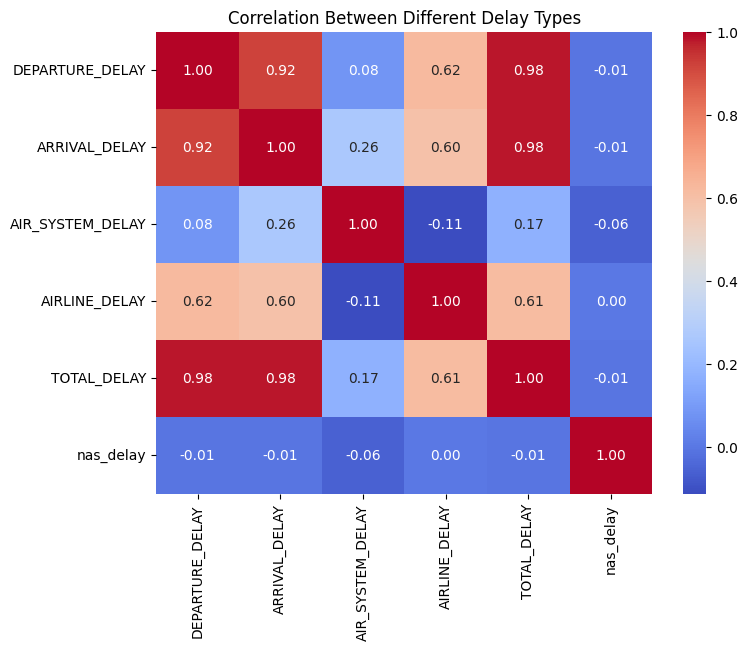

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

delay_cols = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 'AIRLINE_DELAY', 'TOTAL_DELAY', 'nas_delay']
plt.figure(figsize=(8,6))
sns.heatmap(sample_df[delay_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Different Delay Types")
plt.show()


/tmp/ipython-input-1780340703.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




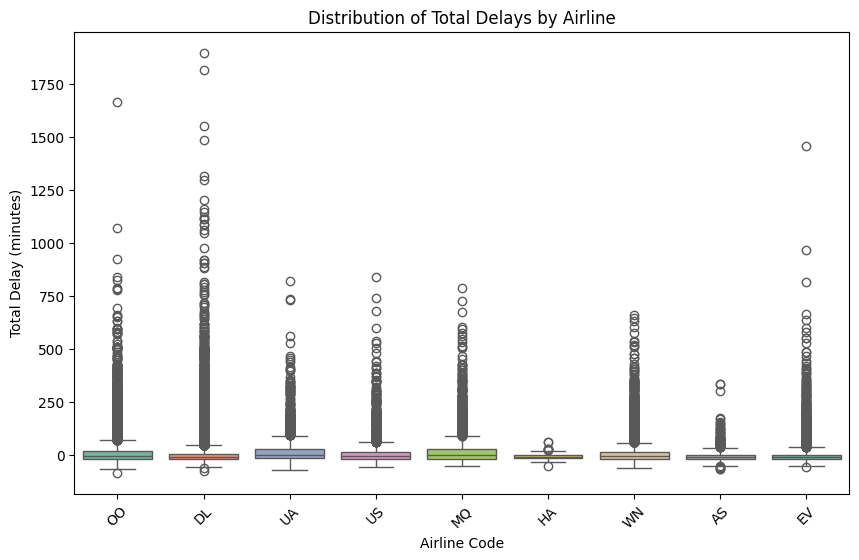

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(data=sample_df, x='AIRLINE', y='TOTAL_DELAY', palette='Set2')
plt.title("Distribution of Total Delays by Airline")
plt.xlabel("Airline Code")
plt.ylabel("Total Delay (minutes)")
plt.xticks(rotation=45)
plt.show()


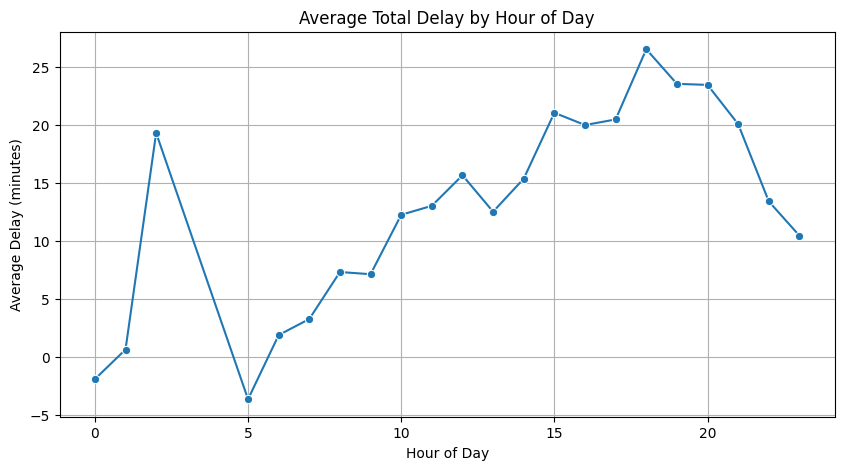

In [25]:
sample_df['HOUR'] = (sample_df['SCHEDULED_DEPARTURE'] // 100).astype(int)

hourly_trend = sample_df.groupby('HOUR')['TOTAL_DELAY'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_trend, x='HOUR', y='TOTAL_DELAY', marker='o')
plt.title("Average Total Delay by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Delay (minutes)")
plt.grid(True)
plt.show()


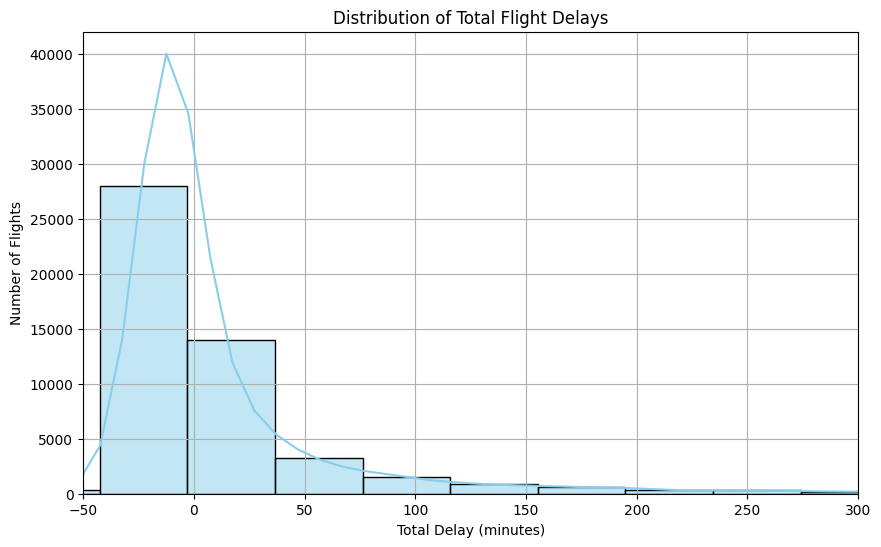

In [26]:
plt.figure(figsize=(10,6))
sns.histplot(sample_df['TOTAL_DELAY'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Total Flight Delays")
plt.xlabel("Total Delay (minutes)")
plt.ylabel("Number of Flights")
plt.xlim(-50, 300)
plt.grid(True)
plt.show()


/tmp/ipython-input-329135818.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




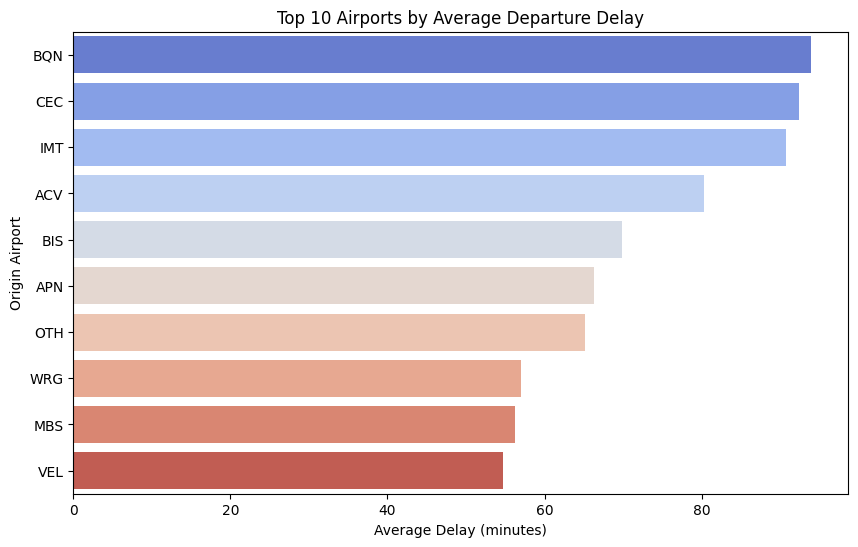

In [27]:
top_airports = (
    sample_df.groupby('ORIGIN_AIRPORT')['TOTAL_DELAY']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(data=top_airports, x='TOTAL_DELAY', y='ORIGIN_AIRPORT', palette='coolwarm')
plt.title("Top 10 Airports by Average Departure Delay")
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Origin Airport")
plt.show()


/tmp/ipython-input-1021565418.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




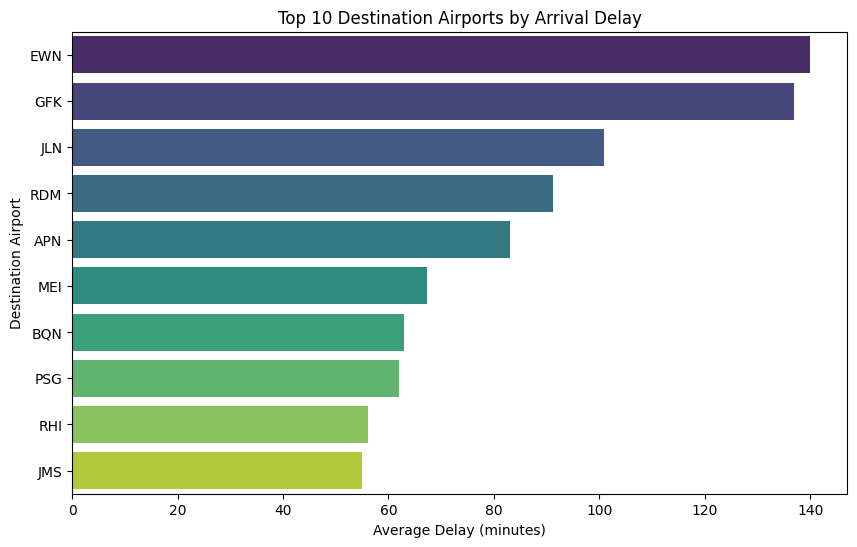

In [28]:
top_dest = (
    sample_df.groupby('DESTINATION_AIRPORT')['TOTAL_DELAY']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(data=top_dest, x='TOTAL_DELAY', y='DESTINATION_AIRPORT', palette='viridis')
plt.title("Top 10 Destination Airports by Arrival Delay")
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Destination Airport")
plt.show()


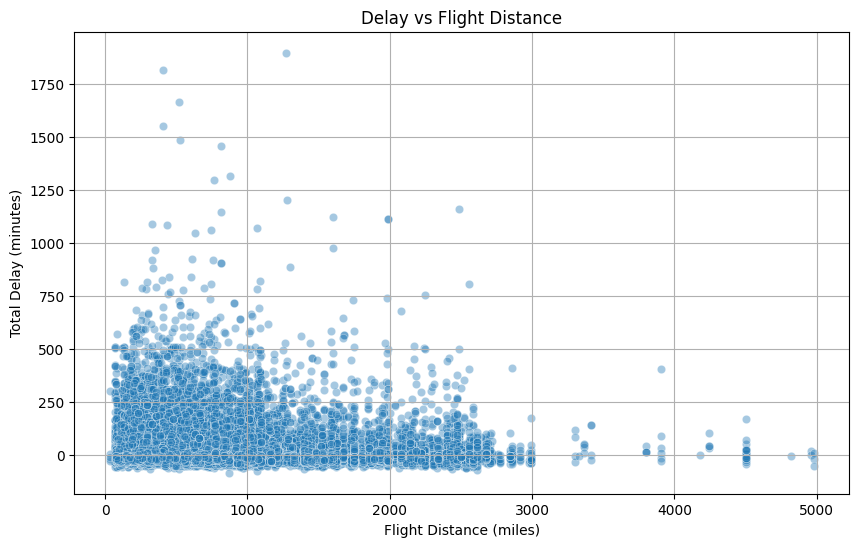

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=sample_df, x='DISTANCE', y='TOTAL_DELAY', alpha=0.4)
plt.title("Delay vs Flight Distance")
plt.xlabel("Flight Distance (miles)")
plt.ylabel("Total Delay (minutes)")
plt.grid(True)
plt.show()


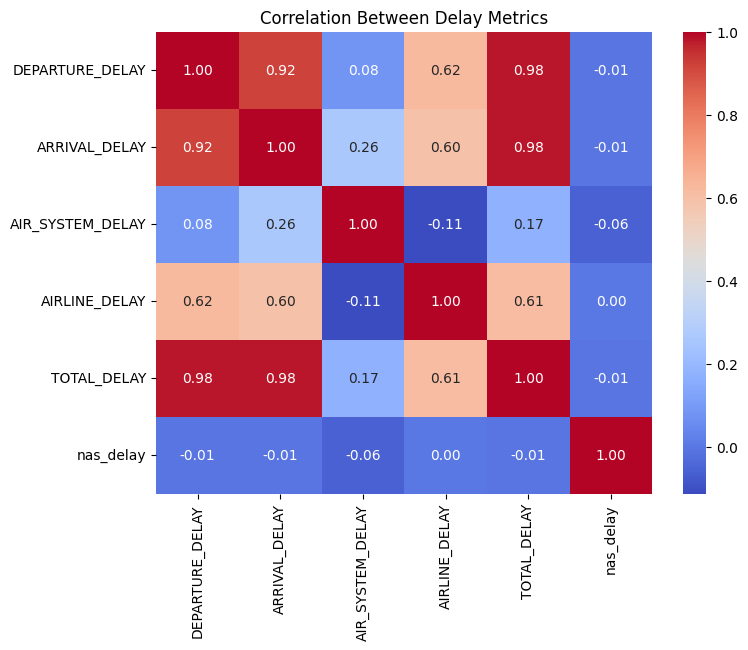

In [30]:
delay_cols = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 'AIRLINE_DELAY', 'TOTAL_DELAY', 'nas_delay']
plt.figure(figsize=(8,6))
sns.heatmap(sample_df[delay_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Delay Metrics")
plt.show()


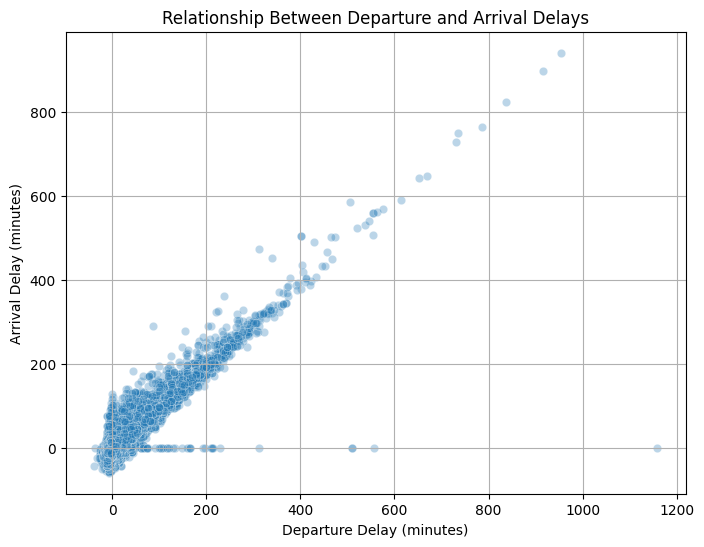

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=sample_df, x='DEPARTURE_DELAY', y='ARRIVAL_DELAY', alpha=0.3)
plt.title("Relationship Between Departure and Arrival Delays")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Arrival Delay (minutes)")
plt.grid(True)
plt.show()


In [32]:
print("Average Total Delay:", round(sample_df['TOTAL_DELAY'].mean(), 2), "minutes")
print("Median Total Delay:", round(sample_df['TOTAL_DELAY'].median(), 2), "minutes")
print("Flights with delay > 60 mins:", (sample_df['TOTAL_DELAY'] > 60).mean() * 100, "%")


Average Total Delay: 14.17 minutes
Median Total Delay: -6.0 minutes
Flights with delay > 60 mins: 10.716000000000001 %


/tmp/ipython-input-1135710706.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




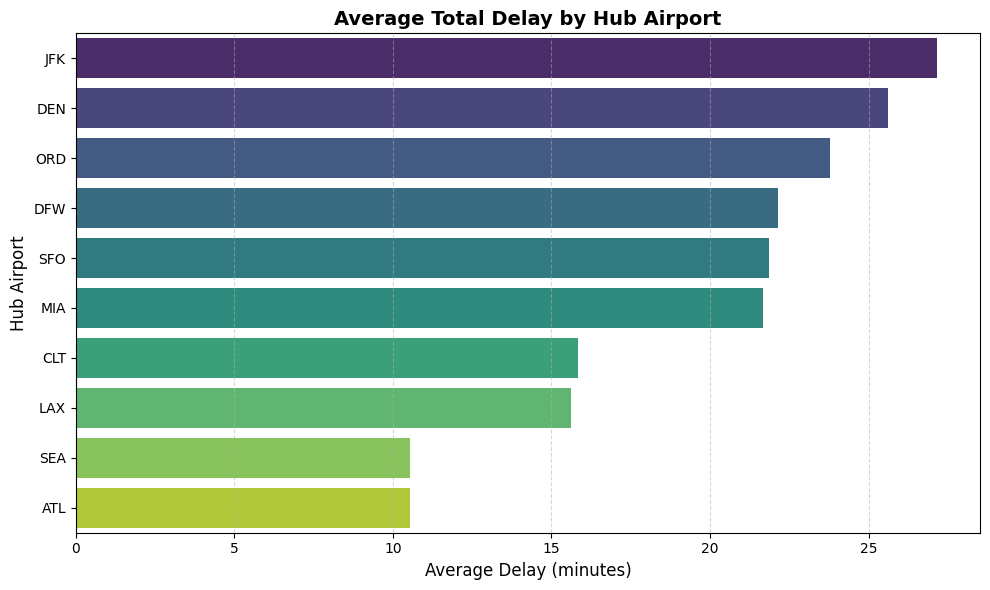

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for hub airports
hub_df = sample_df[sample_df["ORIGIN_IS_HUB"] == 1].copy()

# Calculate average total delay for each hub airport
avg_delay_hub = (
    hub_df.groupby('ORIGIN_AIRPORT')['TOTAL_DELAY'].mean().reset_index()
)

# Sort for better visualization
avg_delay_hub = avg_delay_hub.sort_values("TOTAL_DELAY", ascending=False)

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_delay_hub, x='TOTAL_DELAY', y='ORIGIN_AIRPORT', palette='viridis')

# Chart aesthetics
plt.title("Average Total Delay by Hub Airport", fontsize=14, fontweight="bold")
plt.xlabel("Average Delay (minutes)", fontsize=12)
plt.ylabel("Hub Airport", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()